# 取得股價資料

In [1]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件

In [2]:
# 輸入股票代號
stock_id = "8374.tw"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

'''抓取特定時間'''
# start = dt.datetime(2024, 1, 1)  # 指定的開始日期
# end = dt.datetime(2024, 6, 30)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
data = yf.download(stock_id, start=start, end=end).reset_index()

df = data.copy()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-26,30.85,31.549999,30.850000,30.900000,30.819740,141000
1,2024-04-29,30.85,31.200001,30.700001,30.799999,30.719999,108712
2,2024-04-30,30.90,31.100000,30.799999,31.100000,31.019222,55000
3,2024-05-02,31.10,31.500000,31.049999,31.299999,31.218700,76646
4,2024-05-03,31.25,31.250000,30.650000,30.700001,30.620260,106000
...,...,...,...,...,...,...,...
114,2024-10-15,127.50,131.500000,126.000000,128.000000,128.000000,2575589
115,2024-10-16,130.50,140.500000,130.000000,140.500000,140.500000,6570370
116,2024-10-17,145.50,151.500000,140.500000,141.500000,141.500000,30819186
117,2024-10-18,145.00,148.000000,137.000000,142.500000,142.500000,12979405


In [3]:
df.to_csv(f'{stock_id}.csv', index=False)

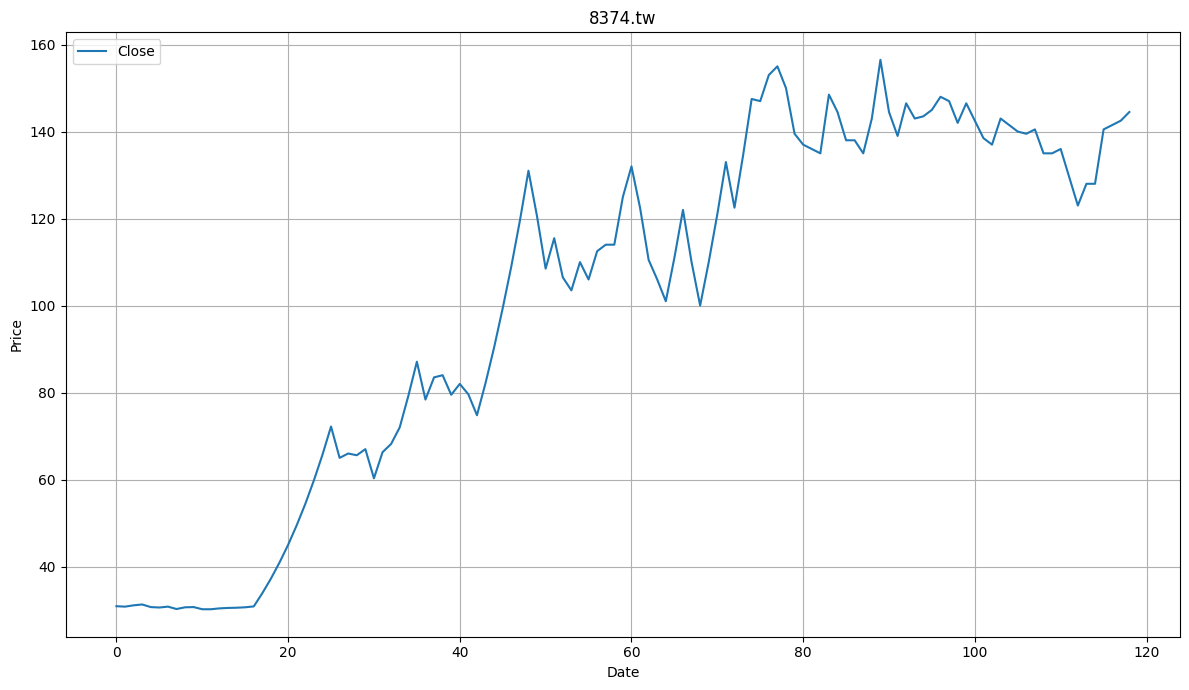

In [4]:
import matplotlib.pyplot as plt

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Close'], label='Close')

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()  # 自動調整圖表中的間距，避免元素之間的重疊

# 顯示圖表
plt.show()

In [5]:
# 將原始資料複製出兩份，一個給機器學習使用，另外一個給統計模型使用
df_ml = df.copy()  # 給機器學習使用的資料副本
df_stat = df.copy()  # 給統計模型使用的資料副本

# <b>1. 技術指標的計算</b>
移動動平均線（MA）、相對強弱指數（RSI）、平滑異同移動平均線（MACD）


## 1.1 計算簡單移動平均線（SMA）

In [6]:
# 計算8日 SMA
df_ml['8_SMA'] = df_ml['Close'].rolling(window=8).mean()

# 計算13日 SMA
df_ml['13_SMA'] = df_ml['Close'].rolling(window=13).mean()

# 計算20日 SMA
df_ml['20_SMA'] = df_ml['Close'].rolling(window=20).mean()

# 列印最後筆數
df_ml.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,8_SMA,13_SMA,20_SMA
114,2024-10-15,127.5,131.5,126.0,128.0,128.0,2575589,131.8750,135.076923,138.275
115,2024-10-16,130.5,140.5,130.0,140.5,140.5,6570370,131.8750,135.346154,138.050
116,2024-10-17,145.5,151.5,140.5,141.5,141.5,30819186,132.6875,135.230769,137.725
117,2024-10-18,145.0,148.0,137.0,142.5,142.5,12979405,133.6250,135.307692,137.500
118,2024-10-21,143.5,144.5,140.0,144.5,144.5,4763368,134.6875,135.653846,137.625


## 1.2 計算相對強弱指數（RSI）

In [7]:
# 計算每個交易日的價格變動，即當天收盤價與前一天收盤價的差異
df_ml['Change'] = df_ml['Close'] - df_ml['Close'].shift(1)

# 將變動值中的正數部分視為“Gain”（增益），如果變動為負則記為0
df_ml['Gain'] = df_ml['Change'].apply(lambda x: x if x > 0 else 0)

# 將變動值中的負數部分視為“Loss”（損失），取其絕對值，如果變動為正則記為0
df_ml['Loss'] = df_ml['Change'].apply(lambda x: abs(x) if x < 0 else 0)

df_ml.tail()

# 計算過去14個交易日的平均增益
df_ml['Avg Gain'] = df_ml['Gain'].rolling(window=14).mean()

# 計算過去14個交易日的平均損失
df_ml['Avg Loss'] = df_ml['Loss'].rolling(window=14).mean()

# 計算相對強弱指數的相對強度（RS），即平均增益與平均損失的比值
df_ml['RS'] = df_ml['Avg Gain'] / df_ml['Avg Loss']

# 計算相對強弱指數（RSI），使用RS公式計算出來
df_ml['RSI'] = 100 - (100 / (1 + df_ml['RS']))

# 顯示最後幾行的數據
df_ml.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
114,2024-10-15,127.5,131.5,126.0,128.0,128.0,2575589,131.8750,135.076923,138.275,0.0,0.0,0.0,0.928571,1.964286,0.472727,32.098765
115,2024-10-16,130.5,140.5,130.0,140.5,140.5,6570370,131.8750,135.346154,138.050,12.5,12.5,0.0,1.821429,1.678571,1.085106,52.040816
116,2024-10-17,145.5,151.5,140.5,141.5,141.5,30819186,132.6875,135.230769,137.725,1.0,1.0,0.0,1.892857,1.571429,1.204545,54.639175
117,2024-10-18,145.0,148.0,137.0,142.5,142.5,12979405,133.6250,135.307692,137.500,1.0,1.0,0.0,1.535714,1.571429,0.977273,49.425287
118,2024-10-21,143.5,144.5,140.0,144.5,144.5,4763368,134.6875,135.653846,137.625,2.0,2.0,0.0,1.678571,1.464286,1.146341,53.409091


## 1.3 計算平滑異同移動平均線（MACD）

In [8]:
'''
第一日
# 平滑係數公式： α = 2 / (span + 1) = 2 / (span + 1)
# α = 2 / (8 + 1) = 2 / (8 + 1) ≈ 0.2222
# 0.2222 * 770.0 + (1-0.2222) * 776.0 = 171.094 + 603.5728 = 774.6668
'''

# 計算8天的指數移動平均線（EMA），並將其存儲在 '8_EMA' 列中
# adjust=False 表示在計算 EMA 時，只考慮當前值和前一個 EMA 的遞歸計算方式，而不考慮所有歷史數據
df_ml['8_EMA'] = df_ml['Close'].ewm(span=8, adjust=False).mean()

# 計算13天的指數移動平均線（EMA），並將其存儲在 '13_EMA' 列中
df_ml['13_EMA'] = df_ml['Close'].ewm(span=13, adjust=False).mean()

# 計算MACD線：8天EMA減去13天EMA，並將其存儲在 'MACD' 列中
df_ml['MACD'] = df_ml['8_EMA'] - df_ml['13_EMA']

# 顯示DataFrame的最後幾行數據
df_ml.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,8_EMA,13_EMA,MACD
0,2024-04-26,30.85,31.549999,30.850000,30.900000,30.819740,141000,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,30.900000,30.900000,0.000000
1,2024-04-29,30.85,31.200001,30.700001,30.799999,30.719999,108712,NaN,NaN,NaN,-0.100000,0.000000,0.1,NaN,NaN,NaN,NaN,30.877777,30.885714,-0.007937
2,2024-04-30,30.90,31.100000,30.799999,31.100000,31.019222,55000,NaN,NaN,NaN,0.300001,0.300001,0.0,NaN,NaN,NaN,NaN,30.927160,30.916326,0.010834


# <b>2. 機器學習預測股價漲跌</b>
技術指標當特徵，用線性回歸、決策樹、隨機森林預測股價漲跌

## 2.1 資料前處理

In [9]:
import numpy as np  # 引入 numpy，用於數據處理和數值運算
from sklearn.model_selection import train_test_split  # 引入 train_test_split，用於將數據集拆分為訓練集和測試集
from sklearn.metrics import mean_squared_error  # 引入 mean_squared_error 用於評估模型性能

In [10]:
# 標籤生成: 預測未來1天的價格，這裡以2024-04-01的技術指標 預測隔天的收盤價
n = 5
df_ml['Future_Price'] = df_ml['Close'].shift(-n)

# 去除缺失值
df_ml.dropna(inplace=True)

# 使用特徵
# X = df_ml[['8_SMA', '13_SMA', '20_SMA', 'RSI', 'MACD']]
X = df_ml[['20_SMA', 'RSI', 'MACD']]

# 標籤（未來價格）
y = df_ml['Future_Price']

X.shape, y.shape

((95, 3), (95,))

In [11]:
# 將數據集 X 和標籤 y 拆分為訓練集和測試集
# test_size=0.2 表示測試集佔全部數據的 20% --> 80% 的資料作為訓練，20% 的資料作為測試
# shuffle=False 表示在拆分數據時不打亂原始數據的順序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看拆分後訓練集和測試集的形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((76, 3), (19, 3), (76,), (19,))

## 2.1 決策樹（Decision Tree）

In [12]:
from sklearn.tree import DecisionTreeRegressor

# 建立並訓練決策數模型
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"決策樹模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"決策樹模型預測未來{n}天的價格: {future_pred[0]:.2f}")

決策樹模型RMSE: 13.23
決策樹模型預測未來5天的價格: 122.50


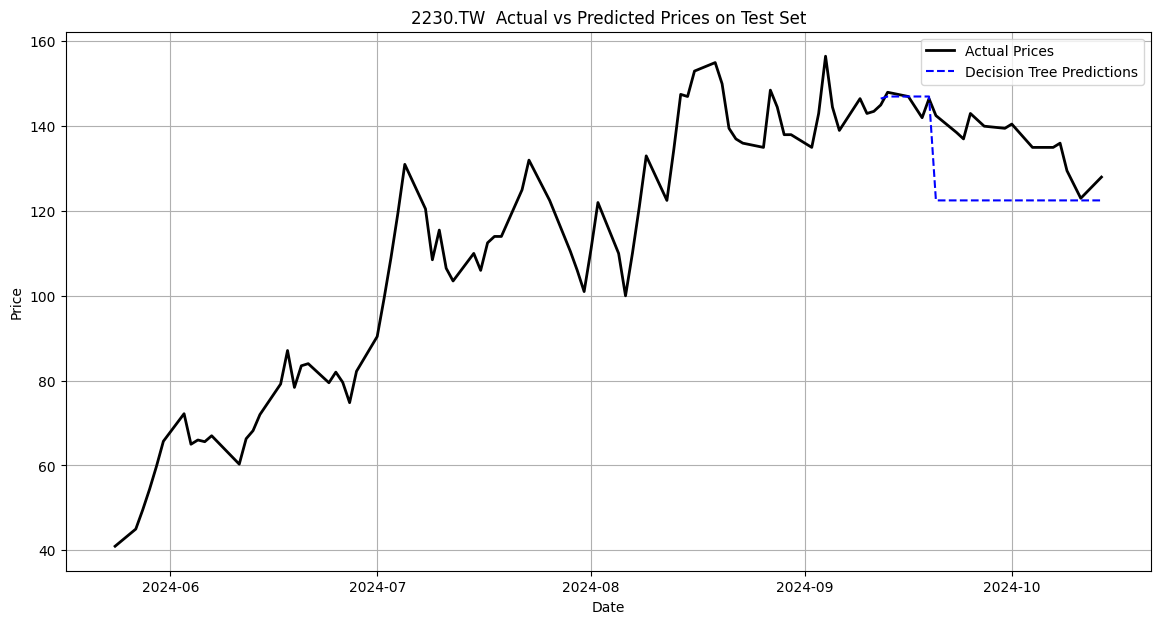

In [13]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df_ml['Date'], df_ml['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df_ml['Date'][-len(y_test):], y_pred, label='Decision Tree Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

## 3.3 隨機森林（Random Forest）

In [14]:
# 引入隨機森林模型
from sklearn.ensemble import RandomForestRegressor

# 建立並訓練決策數模型
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"隨機森林模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"隨機森林模型預測未來{n}天的價格: {future_pred[0]:.2f}")

隨機森林模型RMSE: 5.98
隨機森林模型預測未來5天的價格: 133.57


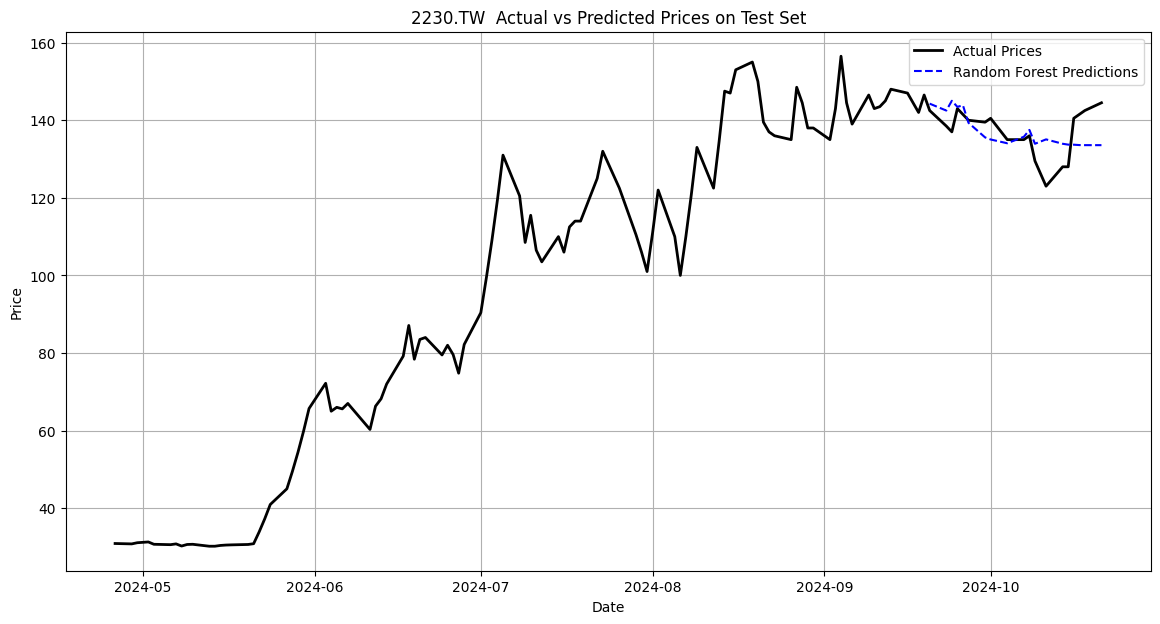

In [15]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Random Forest Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

## 3.4 補充：極限梯度提升（XGBoost）

In [16]:
# 引入XGBoost模型
from xgboost import XGBRegressor

# 建立並訓練 XGBoost 模型
model = XGBRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"XGBoost 模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"XGBoost 模型預測未來 {n} 天的價格: {future_pred[0]:.2f}")

XGBoost 模型RMSE: 9.44
XGBoost 模型預測未來 5 天的價格: 145.51


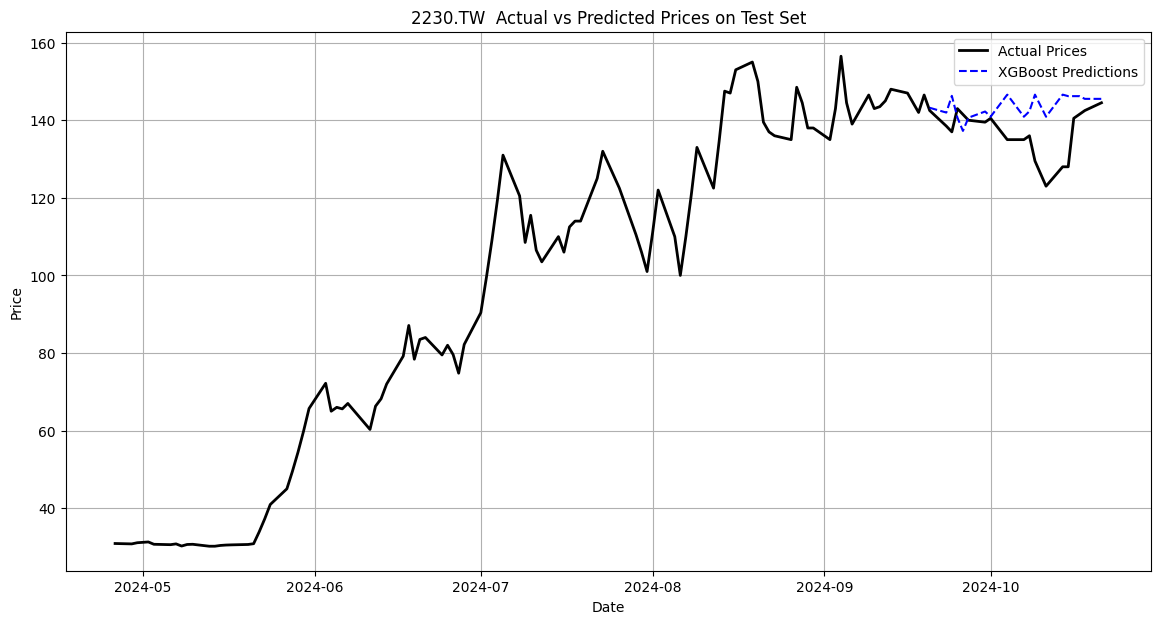

In [17]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='XGBoost Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# <b>3. ARIMA（差分整合移動平均自我迴歸模型）</b>

In [18]:
df_stat['Date'] = pd.to_datetime(df_stat['Date'])
df_stat.set_index('Date', inplace=True)

df_stat

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,30.85,31.549999,30.850000,30.900000,30.819740,141000
2024-04-29,30.85,31.200001,30.700001,30.799999,30.719999,108712
2024-04-30,30.90,31.100000,30.799999,31.100000,31.019222,55000
2024-05-02,31.10,31.500000,31.049999,31.299999,31.218700,76646
2024-05-03,31.25,31.250000,30.650000,30.700001,30.620260,106000
...,...,...,...,...,...,...
2024-10-15,127.50,131.500000,126.000000,128.000000,128.000000,2575589
2024-10-16,130.50,140.500000,130.000000,140.500000,140.500000,6570370
2024-10-17,145.50,151.500000,140.500000,141.500000,141.500000,30819186


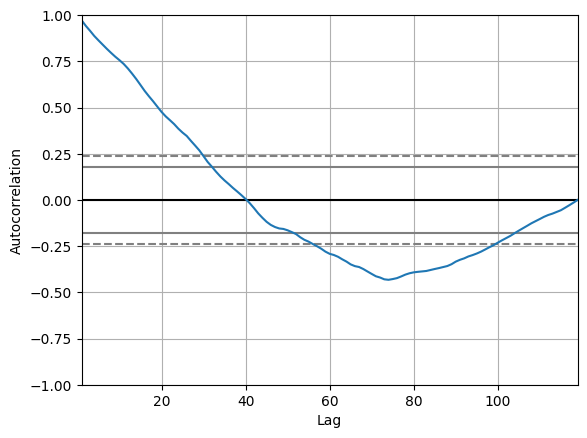

In [19]:
from pandas.plotting import autocorrelation_plot

# 畫出自相關圖
autocorrelation_plot(df_stat['Close'])
plt.show()

## 3.1 資料前處理

In [20]:
# 選擇收盤價作為預測目標
close_prices = df_stat['Close']

# 拆分資料分為訓練集(70%) 和測試集(30%)
train_size = int(len(close_prices) * 0.7)
train, test = close_prices[:train_size], close_prices[train_size:]

print(f"訓練集長度: {len(train)}")
print(f"測試集長度: {len(test)}")

訓練集長度: 83
測試集長度: 36


## 3.2 ARIMA 模型

In [22]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 8.5 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.8 MB 6.5 MB/s eta 0:00:02
   ----------- ---------------------------- 2.9/9.8 MB 6.2 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.8 MB 6.5 MB/s eta 0:00:01
   ------------------------ --------------- 6.0/9.8 MB 6.8 MB/s eta 0:00:01
   ----------------------------- ---------- 7.3/9.8 MB 6.9 MB/s eta 0:00:01
   ----------------------------------- ---- 8.7/9.8 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 6.5 MB/s eta 0:00:00


In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 優化 ARIMA 模型參數的函數
def optimize_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_model = None
    # 使用迴圈迭代 p, d, q 組合找出最佳參數
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    yhat = model_fit.forecast(steps=len(test))
                    error = mean_squared_error(test, yhat)
                    if error < best_score:
                        best_score, best_cfg = error, (p, d, q)
                        best_model = model_fit
                except:
                    continue
    return best_cfg, best_model

# 定義 p, d, q 參數範圍
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# 找出 ARIMA 模型最佳參數
best_cfg, best_model = optimize_arima(train, p_values, d_values, q_values)

# 印出最佳参数
print(f'最佳參數 {best_cfg}')

最佳參數 (2, 1, 4)


In [24]:
# 預測
yhat = best_model.forecast(steps=len(test))

# 計算誤差RMSE
rmse_optimized = sqrt(mean_squared_error(test, yhat))

# 印出誤差RMSE
print(f"RMSE: {rmse_optimized}")

RMSE: 6.8632392828559174


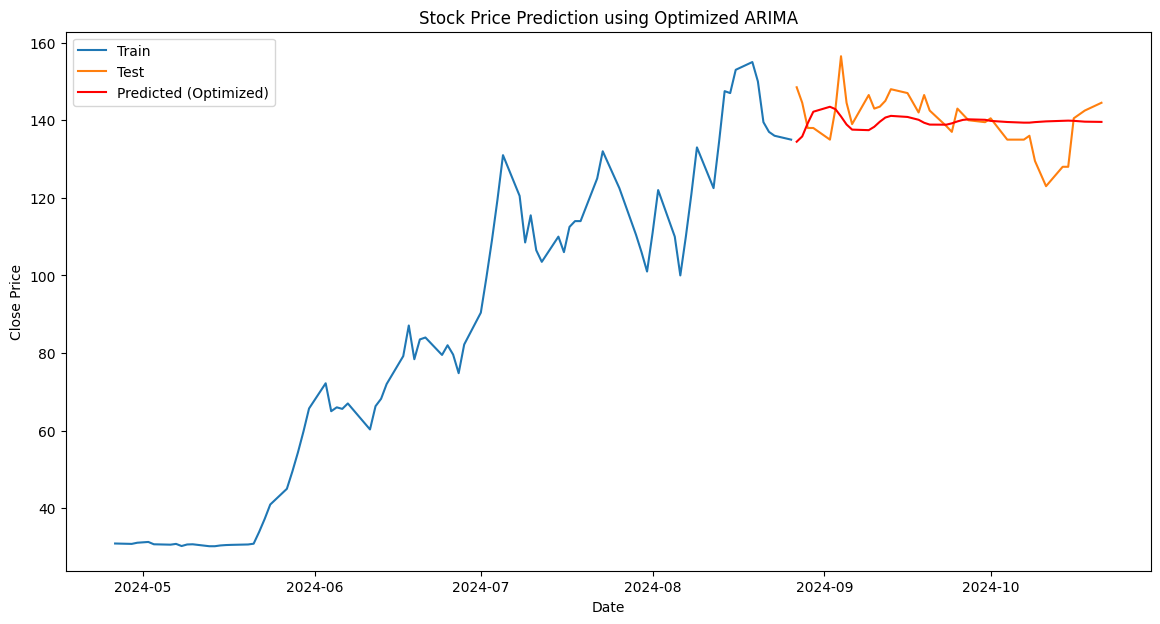

In [25]:
# 繪製折線圖
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, yhat, color='red', label='Predicted (Optimized)')
plt.title('Stock Price Prediction using Optimized ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

RMSE: 6.8632392828559174


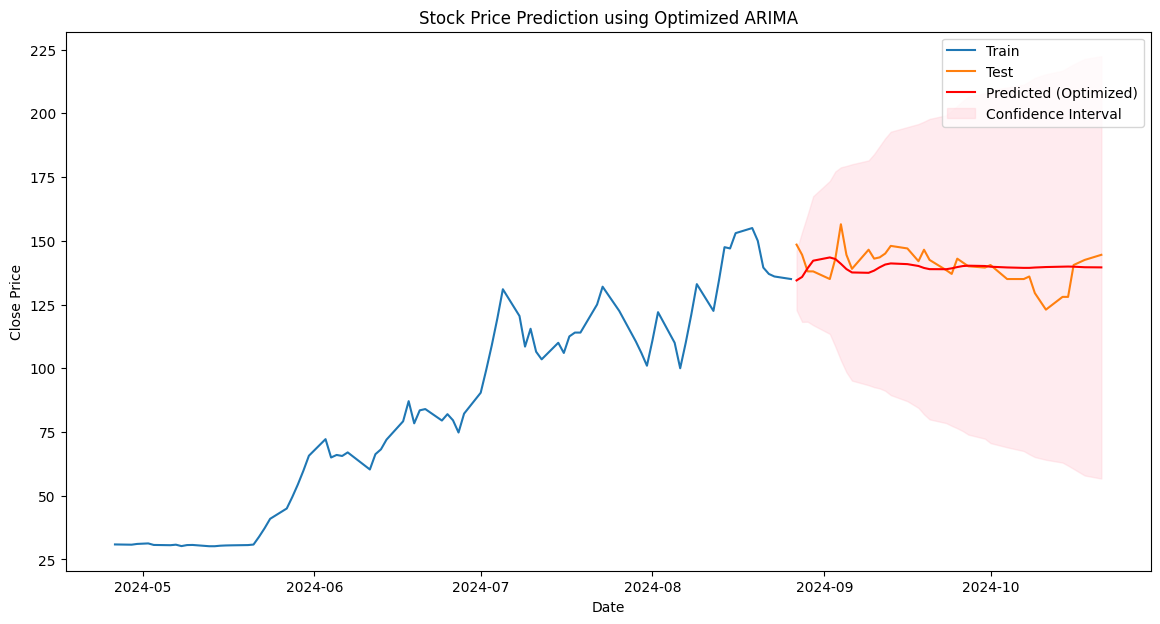

In [26]:
# 使用模型生成預測，包含信賴區間
summary_frame = best_model.get_forecast(steps=len(test)).summary_frame(alpha=0.05)
yhat = summary_frame['mean'].values
stderr = summary_frame['mean_se'].values
conf_int = summary_frame[['mean_ci_lower', 'mean_ci_upper']].values

# 計算誤差RMSE
rmse_optimized = sqrt(mean_squared_error(test, yhat))

# 印出誤差RMSE
print(f"RMSE: {rmse_optimized}")

# 繪製折線圖和信賴區間
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, yhat, color='red', label='Predicted (Optimized)')

# 繪製信賴區間
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Stock Price Prediction using Optimized ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# <b>4. 量化交易策略</b>

###**本次作業要求**

設計並實作一個量化交易策略，並基於歷史數據進行回測，以檢驗策略的有效性。以擇以下其中一種策略來實現，或自行設計一個創新的策略：

* 均值回歸策略：價格在移動平均線上方/下方偏離過大時進行買賣。
* 動量策略：基於價格趨勢進行買入或賣出操作，當價格上升時買入，當價格下降時賣出。

## 4.1 均值回歸策略

**如何產生買入和賣出信號？**

* 黃金交叉（Golden Cross）：當短期移動平均線（短期 MA）從下方突破長期移動平均線（長期 MA），這被認為是一個買入信號。這代表著短期內價格上升的趨勢開始超過長期趨勢，市場可能進入一個上漲階段。

* 死亡交叉（Death Cross）：當短期 MA從上方跌破長期 MA，這被認為是一個賣出信號。這代表著短期內的價格趨勢弱於長期趨勢，市場可能進入下跌階段。

In [27]:
# 輸入股票代號
stock_id = "8374.tw"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''抓取特定時間'''
start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2023, 1, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,22.400000,22.750000,22.400000,22.549999,20.828581,106977
2020-01-03,22.450001,22.549999,22.250000,22.400000,20.690031,74149
2020-01-06,22.549999,22.549999,22.200001,22.299999,20.597664,42450
2020-01-07,22.200001,22.250000,21.950001,22.049999,20.366749,120001
2020-01-08,22.000000,22.100000,21.700001,22.000000,20.320568,155184
...,...,...,...,...,...,...
2022-12-26,29.000000,29.799999,28.799999,29.600000,29.048470,33001
2022-12-27,29.750000,30.250000,29.600000,29.750000,29.195673,40000
2022-12-28,29.750000,30.500000,29.700001,29.850000,29.293810,73748


In [28]:
# 設計均值回歸策略
def mean_reversion_strategy(data, short_window, long_window):
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

    data['Signal'] = 0  # 初始訊號：不操作
    data['Signal'][short_window:] = data['Short_MA'][short_window:] > data['Long_MA'][short_window:]  # 短均線高於長均線，發出買入信號
    data['Position'] = data['Signal'].diff()  # 當訊號有變化時，產生操作
    return data

In [29]:
# 回測策略並可視化結果
def backtest_and_plot(data):
    # 資產淨值初始化
    initial_capital = 100000
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions['Stock'] = data['Signal'] * 100  # 每次交易100股
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    # 計算資產組合的總價值
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')
    plt.plot(data['Short_MA'], label='Short Moving Average', color='green')
    plt.plot(data['Long_MA'], label='Long Moving Average', color='red')

    # 標註買賣點
    plt.plot(data[data['Position'] == 1].index,
             data['Short_MA'][data['Position'] == 1],
             '^', markersize=10, color='r', lw=0, label='Buy Signal')

    plt.plot(data[data['Position'] == -1].index,
             data['Short_MA'][data['Position'] == -1],
             'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('Mean Reversion Strategy Backtest')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

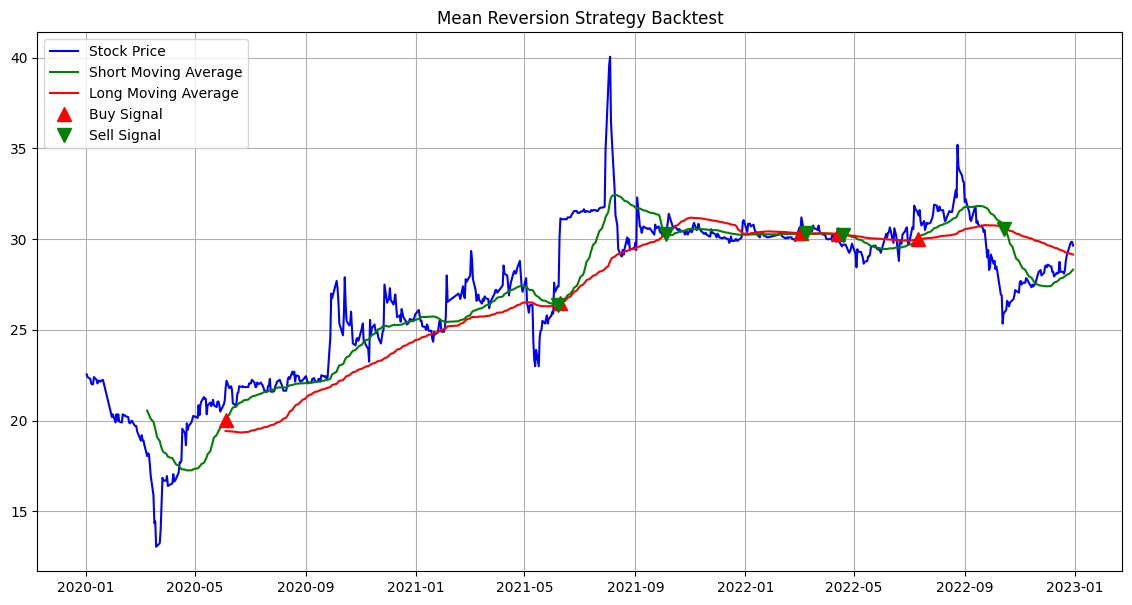

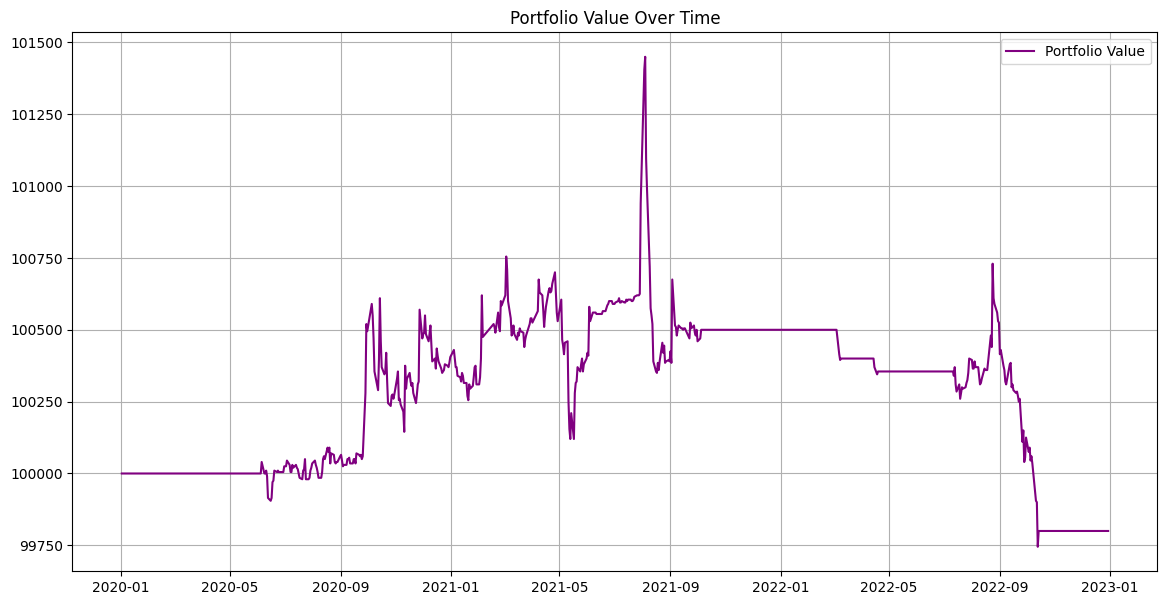

In [30]:
 # 設定策略參數：短期移動平均線窗口與長期移動平均線窗口
short_window = 40
long_window = 100

# 應用均值回歸策略
stock_data = mean_reversion_strategy(stock_data, short_window, long_window)

# 回測並可視化結果
backtest_and_plot(stock_data)

## 4.2 動量策略
**動量策略的基本概念**

1. 趨勢延續：動量策略假設「趨勢具有延續性」。這意味著當某種資產的價格在過去一段時間內持續上升或下降，這個趨勢很有可能在短期內繼續維持。因此，動量策略會根據資產的歷史表現來預測未來的價格變動方向。

2. 上升買入，下降賣出：動量策略的操作原則是「追漲殺跌」：
    * 買入信號：當價格顯示出持續上升的動能時，投資者會進場買入，以期未來價格能夠進一步上漲。
    * 賣出信號：當價格顯示出下降的動能時，投資者會賣出持有的資產，預防價格繼續下跌。

In [31]:
# 輸入股票代號
stock_id = "8374.tw"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''抓取特定時間'''
start = dt.datetime(2023, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 1, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,29.600000,30.000000,29.600000,29.850000,29.293810,46000
2023-01-04,30.000000,30.450001,29.850000,29.850000,29.293810,93004
2023-01-05,29.850000,29.850000,29.500000,29.650000,29.097536,21000
2023-01-06,29.500000,29.549999,29.049999,29.100000,28.557785,39108
2023-01-09,29.100000,29.100000,28.799999,28.850000,28.312445,27000
...,...,...,...,...,...,...
2023-12-25,28.049999,28.200001,27.950001,28.200001,28.126755,20379
2023-12-26,28.150000,28.299999,28.000000,28.299999,28.226494,46000
2023-12-27,28.100000,28.250000,28.100000,28.250000,28.176624,6040


In [32]:
# 動量策略設計 (基於價格變動百分比)
def momentum_strategy(data, window, threshold):
    # 計算動量：基於過去window天的百分比變化
    data['Momentum'] = data['Close'].pct_change(window) * 100  # 轉換為百分比
    data['Signal'] = 0  # 初始訊號

    # 設定當動量變化超過閾值時觸發交易信號
    data['Signal'][window:] = [1 if momentum > threshold else -1 if momentum < -threshold else 0 for momentum in data['Momentum'][window:]]

    data['Position'] = data['Signal'].diff()  # 訊號變化產生操作
    return data

In [33]:
# 回測策略並可視化結果
def backtest_and_plot(data):
    # 初始資本
    initial_capital = 100000
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions['Stock'] = data['Signal'] * 100  # 每次買賣100股
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    # 計算資產組合的總價值
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')

    # 標註買賣信號
    plt.plot(data[data['Position'] == 1].index,
             data['Close'][data['Position'] == 1],
             '^', markersize=10, color='r', lw=0, label='Buy Signal')

    plt.plot(data[data['Position'] == -1].index,
             data['Close'][data['Position'] == -1],
             'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('Momentum Strategy with Percentage Change and Threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

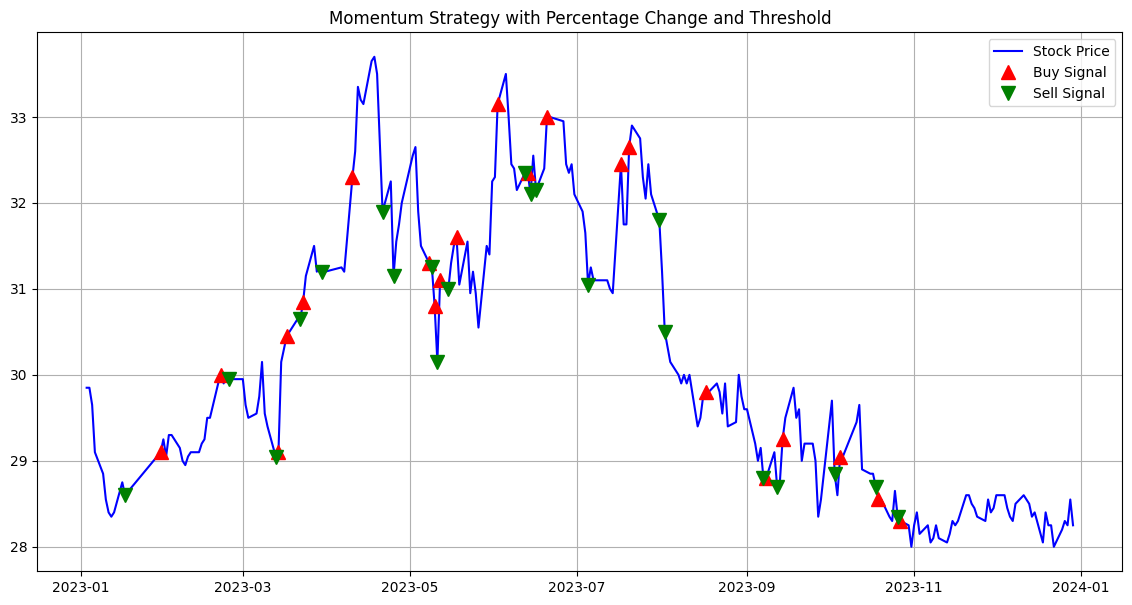

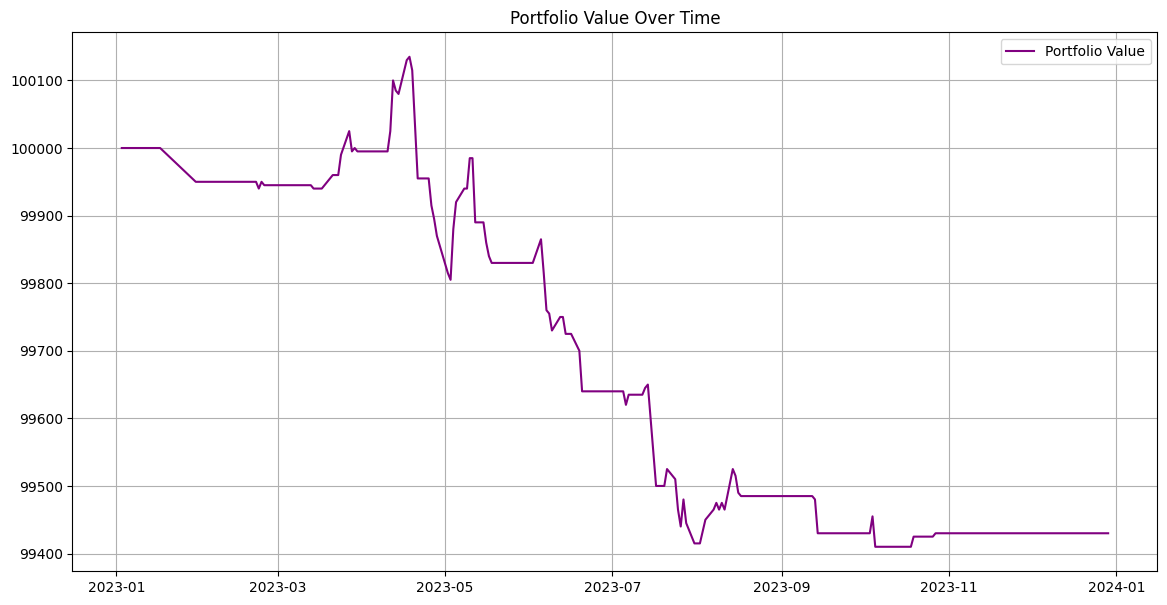

In [34]:
# 設定策略參數：動量計算的窗口期與百分比閾值
momentum_window = 10  # 設定動量窗口為5天
threshold = 3  # 當價格變動百分比超過3%時觸發買賣信號

# 應用動量策略
stock_data = momentum_strategy(stock_data, momentum_window, threshold)

# 回測並可視化結果
backtest_and_plot(stock_data)